In [1]:
from seriesNet_torch import *
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
import random
import glob
from action_500FN import action, load_dataset
import matplotlib.pyplot as plt

In [2]:
action_1 = action('A_data.csv')
#action_2 = action('A_data.csv')
#a = [action_1.to_tensor(), action_2.to_tensor()]
#a = np.stack(a, axis=0)
#CC = torch.tensor(a)
#myAction.data.head()
#print(myAction.data[['open','high','low','close','volume']].to_numpy()[:,1:-1].dtype)
#print(myAction.data.to_numpy(dtype='float64')[:,1:-1].dtype)
all_files = glob.glob(".\\individual_stocks_5yr/" + "/*.csv")

DD = load_dataset(".\\individual_stocks_5yr\\")

DD.size()

505


torch.Size([470, 5, 1259])

In [3]:
print(DD.size()[0])
index = []
for x in range(10):
  index.append(random.randint(1,DD.size()[0]))
print(index)
print(DD[index][3] == DD[index[3]])


SyntaxError: invalid syntax (<ipython-input-3-0e25255ea3a4>, line 7)

torch.Size([5, 1259])
torch.Size([5, 1])
tensor(7554)
tensor(0)
torch.Size([1259])


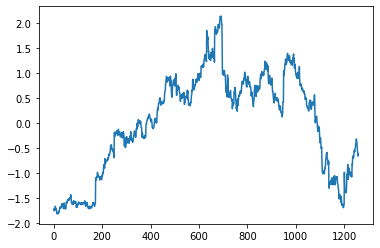

In [4]:
choice = torch.multinomial(torch.tensor(np.arange(DD.size()[0])).float(), 2)
DD[choice].size()
#print((DD.sum(axis=2)/DD.size()[2]) == DD.mean(axis=2))
DD.std(axis=2).size()
print(DD[0].size())
print(DD.mean(axis=2)[0].reshape(5,1).size())
AA = DD - DD.mean(axis=2).reshape(470,5,1)
#print(DD.std(axis=2).reshape(470,5,1))
#print((DD - DD.mean(axis=2).reshape(470,5,1)) / DD.std(axis=2).reshape(470,5,1))


AA = (DD - DD.mean(axis=2).reshape(470,5,1)) / DD.std(axis=2).reshape(470,5,1)

print(torch.isnan(AA).sum())

AA[torch.isnan(AA)] = 0

print(torch.isnan(AA).sum())
print(AA[2,1].size())
plt.plot(AA[2,1])

In [5]:
random.choice(np.arange(470))

325

In [6]:
# LES DATA DOIVENT ETRE DE LA FORME (N, C, TIMESERIES) OU N EST LE NOMBRE D'ELEMENTS DANS LA MINI BATCH
# C LE NOMBRE DE CANAUX, ET TIMESERIES LE NOMBRE DE POINTS DANS LA SERIE CHRONOLOGIQUE
#print(CC.size())
# SEPARER LES CIBLES DE L'OUTPUT
data = AA[:,:,:-1].float()

target = AA[:,:,1:].float()

N = 10
# INITIALISER LE MODELE :
myModel = seriesNet(5, 5)
myModel = myModel.float()
#print(myModel)
print("test 3")
#for param in myModel.parameters():
#    print(param)
#print(data.type())
# OUTPUT

#output2 = myModel(data)
#print("test 1")
#print(output - output2)

# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.0001, weight_decay=0.01)
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(3000):
    choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), N)
    output = myModel(data[choice])
    #print(output)
    optimizer.zero_grad()
    loss = criterion(output, target[choice])  
    print(" loss : ", loss)
    loss.backward()
    #print(myModel.conv_final.weight.grad)
    #print("test 2 ")
    #print(myModel.gated_block2.conv.weight.grad)
    optimizer.step()



test 3
 loss :  tensor(1.6853, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7738, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7940, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7669, grad_fn=<MseLossBackward>)
 loss :  tensor(1.8199, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7631, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7397, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7461, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7323, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7122, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7409, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7769, grad_fn=<MseLossBackward>)
 loss :  tensor(1.6878, grad_fn=<MseLossBackward>)
 loss :  tensor(1.6979, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7026, grad_fn=<MseLossBackward>)
 loss :  tensor(1.7103, grad_fn=<MseLossBackward>)
 loss :  tensor(1.6676, grad_fn=<MseLossBackward>)
 loss :  tensor(1.6774, grad_fn=<MseLossBackward>)
 loss :  tensor(1.6807, grad_fn=<MseLossBackward>)
 loss :  tensor(1.6501, 

 loss :  tensor(1.1645, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1700, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1638, grad_fn=<MseLossBackward>)
 loss :  tensor(1.0907, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1604, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1676, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1606, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1537, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1555, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1465, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1533, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1539, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1306, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1352, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1479, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1344, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1351, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1271, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1244, grad_fn=<MseLossBackward>)
 loss :  tensor(1.1285, grad_fn

 loss :  tensor(0.9532, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9498, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8942, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9445, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9299, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9448, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9432, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9377, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9446, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9392, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9404, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9351, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9347, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9461, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9233, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9299, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9399, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8938, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8695, grad_fn=<MseLossBackward>)
 loss :  tensor(0.9328, grad_fn

 loss :  tensor(0.8673, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8471, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8628, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8453, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8536, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8579, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8551, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8461, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8490, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8494, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8572, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8524, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8596, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8653, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8535, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8461, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8461, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8527, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8435, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8410, grad_fn

 loss :  tensor(0.8000, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8258, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8067, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8252, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7629, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8013, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7615, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8004, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7963, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8069, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7992, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8166, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8261, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8015, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7720, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8155, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8146, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8053, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8410, grad_fn=<MseLossBackward>)
 loss :  tensor(0.8205, grad_fn

 loss :  tensor(0.7989, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7714, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7765, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7847, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7583, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7727, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7530, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7846, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7898, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7792, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7608, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7778, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7896, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7642, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7909, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7689, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7868, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7546, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7720, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7931, grad_fn

 loss :  tensor(0.7667, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7557, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7488, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7360, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7725, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7839, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7717, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7601, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7448, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7240, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7491, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7589, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7463, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7548, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7582, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7506, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7661, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7163, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7469, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7438, grad_fn

 loss :  tensor(0.7396, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7495, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7477, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7300, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7496, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7223, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7161, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7356, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7174, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7246, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7364, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7364, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7269, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7150, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7350, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7187, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7086, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7067, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7307, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7211, grad_fn

 loss :  tensor(0.7368, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7199, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7340, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7218, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7150, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7101, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7038, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7175, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7055, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7260, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7178, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6985, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6957, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7317, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7198, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7025, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7035, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7076, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7189, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6910, grad_fn

 loss :  tensor(0.6779, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7025, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7047, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6838, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6930, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7007, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6927, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7342, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7111, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6982, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6744, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6885, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7030, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6969, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7144, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6868, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6793, grad_fn=<MseLossBackward>)
 loss :  tensor(0.7022, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6923, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6775, grad_fn

 loss :  tensor(0.6589, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6651, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6983, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6711, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6782, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6754, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6479, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6684, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6515, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6555, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6785, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6832, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6673, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6705, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6268, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6613, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6738, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6607, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6399, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6562, grad_fn

 loss :  tensor(0.6572, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6542, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6404, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6785, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6399, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6112, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6549, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6676, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6262, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6647, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6880, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6616, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6806, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6691, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6626, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6361, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6499, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6721, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6570, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6962, grad_fn

 loss :  tensor(0.6609, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6499, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6558, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6415, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6696, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6674, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6498, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6299, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6449, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6527, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6518, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6507, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6692, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6506, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6402, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6230, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6558, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6359, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6397, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6552, grad_fn

 loss :  tensor(0.6354, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6155, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6330, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6419, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6279, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6280, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6374, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6411, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6399, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6336, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6700, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6225, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6448, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6293, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6630, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6502, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6334, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6279, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6311, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6534, grad_fn

 loss :  tensor(0.6694, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6429, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6277, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6344, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6152, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6466, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6550, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6262, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6273, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6236, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6141, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6344, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6194, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6342, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6378, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6112, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6578, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6111, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6402, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6278, grad_fn

 loss :  tensor(0.6023, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6240, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6052, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6093, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6204, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6152, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6238, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6436, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6193, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6156, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6129, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6121, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6395, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6022, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6375, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5871, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6420, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5973, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5949, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5938, grad_fn

 loss :  tensor(0.5924, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5941, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5882, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6169, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5948, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6238, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6001, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5982, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6259, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5903, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6261, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5949, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6162, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5988, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5878, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5868, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5881, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6468, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6349, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6269, grad_fn

 loss :  tensor(0.5836, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5689, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6005, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5831, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6058, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6069, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6234, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5943, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6140, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6012, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6007, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5967, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5787, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6013, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5875, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5845, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6028, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5955, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5824, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5976, grad_fn

 loss :  tensor(0.5714, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5755, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6087, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5673, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6091, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6024, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6015, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5647, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5545, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6256, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5677, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6070, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5969, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5861, grad_fn=<MseLossBackward>)
 loss :  tensor(0.6077, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5690, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5976, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5863, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5987, grad_fn=<MseLossBackward>)
 loss :  tensor(0.5940, grad_fn

torch.Size([1, 5, 1258])


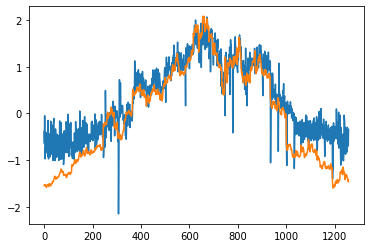

In [9]:
i=random.choice(np.arange(470))

output = myModel(data[i:i+1])
print(output.size())
plt.plot(output[0,1].detach().numpy())
plt.plot(target[i,1])